# IT Service Ticket Classification

## Objetivo

Desenvolver um sistema de classificação automática de tickets de suporte de TI que:
- **Entrada:** texto do ticket (string)
- **Saída:** `{"classe": "...", "justificativa": "..."}`

## Dataset

Utilizamos o dataset [IT Service Ticket Classification](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset), que contém ~48.000 tickets de suporte de TI rotulados em 8 categorias.

## Abordagem: RAG + LLM

Utilizamos **RAG (Retrieval Augmented Generation)** combinado com um **LLM (Large Language Model)**:

1. **Retrieval:** Buscar tickets similares no dataset de treino usando embeddings semânticos
2. **Augmented:** Enriquecer o prompt com exemplos relevantes
3. **Generation:** LLM classifica e justifica baseado no contexto

Esta abordagem foi escolhida porque:
- Temos um dataset grande (~48k tickets) com rótulos confiáveis
- Tickets similares tendem a pertencer à mesma classe
- Exemplos concretos ajudam a LLM a gerar justificativas precisas

## Notebooks

- `analise.ipynb`: Análise exploratória dos dados
- `main.ipynb` (este): Implementação e demonstração da solução

## 1. Carregamento e Preparação dos Dados

### Amostragem Balanceada

Para avaliação, utilizamos **amostragem balanceada** em vez de estratificada:

| Tipo | Descrição |
|------|-----------|
| **Estratificada** | Mantém a proporção original (classes raras têm poucas amostras) |
| **Balanceada** | Mesmo número de amostras por classe |

**Por que balanceada?**
1. **Classes minoritárias importam** - Um classificador que falha em classes raras não é aceitável
2. **Métricas confiáveis** - 25 amostras por classe permitem avaliação estatisticamente significativa

In [1]:
from classifier.data import load_dataset, train_test_split_balanced

In [2]:
# Carregar dataset
df, classes = load_dataset()
print(f"Total de tickets: {len(df):,}")
df.head()

Total de tickets: 47,837


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [3]:
# Classes obtidas do dataset
print(f"Classes ({len(classes)}):")
for c in classes:
    print(f"  - {c}")

Classes (8):
  - Access
  - Administrative rights
  - HR Support
  - Hardware
  - Internal Project
  - Miscellaneous
  - Purchase
  - Storage


In [4]:
from classifier.config import TEST_SIZE

# Split balanceado: treino para RAG, teste para avaliação
# Amostragem balanceada garante o mesmo número de tickets por classe (200 / 8 = 25)
train_df, test_df = train_test_split_balanced(df, test_size=TEST_SIZE)

print(f"Treino: {len(train_df):,} tickets")
print(f"Teste:  {len(test_df)} tickets")
print(f"\nDistribuição no teste:")
print(test_df["Topic_group"].value_counts().sort_index())

Treino: 47,637 tickets
Teste:  200 tickets

Distribuição no teste:
Topic_group
Access                   25
Administrative rights    25
HR Support               25
Hardware                 25
Internal Project         25
Miscellaneous            25
Purchase                 25
Storage                  25
Name: count, dtype: int64


## 2. Por que RAG?

### Alternativas Consideradas

1. **Fine-tuning de LLM:** Treinar um modelo específico para a tarefa. Requer recursos computacionais significativos e risco de overfitting.

2. **Classificador tradicional (ML):** Usar TF-IDF + SVM ou similar. Boa precisão, mas não gera justificativas naturais.

3. **Zero-shot com LLM:** Usar apenas as descrições das classes. Funciona, mas perde a riqueza dos exemplos reais.

4. **RAG (escolhido):** Combina o melhor dos mundos - usa exemplos reais para guiar a classificação e aproveita a capacidade do LLM para justificar.

### Por que RAG é adequado para este problema?

Com base na análise exploratória (`analise.ipynb`):

- **Dataset grande e rotulado:** ~48k tickets com labels confiáveis permitem encontrar exemplos similares
- **Desbalanceamento:** Classes minoritárias (ex: Administrative rights ~3.7%) se beneficiam de exemplos específicos
- **Textos curtos:** Mediana de ~26 palavras facilita o processamento de múltiplos exemplos no prompt
- **Padrões de vocabulário:** Cada classe tem palavras-chave distintas que embeddings capturam bem

### Vantagens desta abordagem

1. **Justificativas de qualidade:** LLM vê exemplos reais e pode referenciar padrões similares
2. **Adaptável:** Novos tickets de treino melhoram automaticamente o retrieval
3. **Explicável:** Podemos inspecionar quais exemplos influenciaram a decisão

## 3. RAG - Retrieval de Tickets Similares

### Como funciona

1. **Embeddings:** Cada ticket é convertido em um vetor de 384 dimensões usando o modelo `all-MiniLM-L6-v2` (sentence-transformers). Este modelo foi treinado para capturar similaridade semântica.

2. **Similaridade de cosseno:** Para encontrar tickets similares, calculamos o cosseno do ângulo entre vetores. Valores próximos de 1 indicam alta similaridade.

3. **Tickets representativos:** Para cada classe, calculamos o "centróide" (média dos embeddings) e selecionamos o ticket mais próximo. Isso nos dá um exemplo típico de cada classe.

### Componentes

- `TicketRetriever.index()`: Gera embeddings para todos os tickets de treino
- `TicketRetriever.retrieve()`: Busca os K tickets mais similares
- `TicketRetriever.compute_representatives()`: Calcula tickets representativos por classe

In [5]:
from classifier.rag import TicketRetriever

In [6]:
# Indexar tickets de treino
retriever = TicketRetriever()
retriever.index(train_df)

# Calcular tickets representativos de cada classe (centróides)
representatives = retriever.compute_representatives()
print(f"\nTickets representativos calculados para {len(representatives)} classes")

Batches:   0%|          | 0/1489 [00:00<?, ?it/s]


Tickets representativos calculados para 8 classes


In [7]:
# Testar retrieval com um ticket do conjunto de teste
test_ticket = test_df.iloc[1]
query = test_ticket["Document"]
true_class = test_ticket["Topic_group"]

similar = retriever.retrieve(query, k=5)

print(f"Ticket de teste (classe real: {true_class}):")
print(f"{query}\n")
print("Tickets similares recuperados:")
for i, ticket in enumerate(similar, 1):
    print(f"\n{i}. [{ticket['class']}] (score: {ticket['score']:.3f})")
    print(f"   {ticket['text']}")

Ticket de teste (classe real: Access):
enable access card for december pm enable card importance high hi please card thank unit

Tickets similares recuperados:

1. [Access] (score: 0.840)
   access card enabling thursday december pm card dear cantina si va

2. [Access] (score: 0.820)
   access card for thursday july pm card importance high dear colleagues please kindly assign card available colleague thank best regards

3. [Access] (score: 0.798)
   activate access card november pm hi please activate today card thanks

4. [Access] (score: 0.795)
   disable access card thursday february pm disable card hi please disable card broken thanks

5. [Access] (score: 0.791)
   access card to be enabling tuesday pm re starter card enabling tower card va ca si si ii card analyst tuesday pm starter card enabling tower va va analyst ext hub


In [8]:
# Visualizar tickets representativos
print("Tickets representativos (mais próximos do centróide de cada classe):\n")
for class_name in sorted(representatives.keys()):
    t = representatives[class_name]
    print(f"[{class_name}] (score: {t['score']:.3f})")
    print(f"   {t['text']}\n")

Tickets representativos (mais próximos do centróide de cada classe):

[Access] (score: 0.773)
   password reset request maxim pm re confluence hi apologies please resetting client please regards confluence regards friday pm re confluence hello happens actions regards senior actuarial consultant commercial pricing ext st

[Administrative rights] (score: 0.814)
   windows upgrade upgrade analyst ext sent thursday october re upgrade good started process upgrade os faced with problem software center operating contains any updates can you help resolve problem sent tuesday october upgrade hello if you already upgraded your os please ignore also if you member teams please apply upgrade yet thank you you receiving because we approaching scheduled for forced upgrade assets migrated yet before performing upgrade your please document found here carefully attention screen below please contact or should you require any further assistance best regards ext

[HR Support] (score: 0.798)
   access thurs

## 4. Design dos Prompts

O prompt é a interface entre nosso sistema e a LLM. Um bom design de prompt é crucial para obter classificações precisas e justificativas úteis.

### Estrutura do Prompt

O prompt é dividido em duas partes:

1. **System prompt:** Define o papel da LLM (classificador), lista as classes válidas e especifica o formato de saída (JSON)

2. **User prompt:** Contém o ticket a classificar e os exemplos de contexto

### Parâmetros Configuráveis

| Parâmetro | Descrição | Valor Padrão |
|-----------|-----------|--------------|
| `K_SIMILAR` | Número de tickets similares do RAG | 5 |
| `reference_tickets` | Tickets representativos por classe | 1 por classe |

### Trade-offs

- **Mais exemplos similares:** Melhor contexto para classificação, mas aumenta tokens e custo
- **Tickets de referência:** Garante diversidade de classes, essencial para justificativas comparativas
- **Muitos exemplos:** Pode "poluir" o contexto e confundir a LLM

Vamos visualizar como os prompts são gerados:

In [9]:
from classifier.prompts import build_system_prompt, build_user_prompt

In [10]:
# Exemplo 1: System Prompt
system_prompt = build_system_prompt(classes)
print("=== SYSTEM PROMPT ===\n")
print(system_prompt)

=== SYSTEM PROMPT ===

Você é um classificador de tickets de suporte de TI.

Classifique o ticket em UMA das seguintes categorias:
- Access
- Administrative rights
- HR Support
- Hardware
- Internal Project
- Miscellaneous
- Purchase
- Storage

Responda APENAS com JSON no formato:
{"classe": "<categoria>", "justificativa": "<explicação curta de 1-2 frases>"}

A justificativa deve mencionar palavras-chave ou padrões do ticket que justificam a classificação.


In [11]:
# Exemplo 2: User Prompt COM tickets de referência
user_prompt_with_refs = build_user_prompt(query, similar, representatives)
print("=== USER PROMPT (com tickets de referência) ===\n")
print(user_prompt_with_refs)

=== USER PROMPT (com tickets de referência) ===

Classifique o seguinte ticket:

enable access card for december pm enable card importance high hi please card thank unit

## Tickets Similares
1. [Access] access card enabling thursday december pm card dear cantina si va
2. [Access] access card for thursday july pm card importance high dear colleagues please kindly assign card available colleague thank best regards
3. [Access] activate access card november pm hi please activate today card thanks
4. [Access] disable access card thursday february pm disable card hi please disable card broken thanks
5. [Access] access card to be enabling tuesday pm re starter card enabling tower card va ca si si ii card analyst tuesday pm starter card enabling tower va va analyst ext hub

## Tickets de Referência (exemplos de cada classe)
- [Administrative rights] windows upgrade upgrade analyst ext sent thursday october re upgrade good started process upgrade os faced with problem software center operating

In [12]:
# Exemplo 3: User Prompt SEM tickets de referência
# Útil quando queremos usar menos tokens ou quando os similares já são suficientes
user_prompt_no_refs = build_user_prompt(query, similar, reference_tickets=None)
print("=== USER PROMPT (sem tickets de referência) ===\n")
print(user_prompt_no_refs)

=== USER PROMPT (sem tickets de referência) ===

Classifique o seguinte ticket:

enable access card for december pm enable card importance high hi please card thank unit

## Tickets Similares
1. [Access] access card enabling thursday december pm card dear cantina si va
2. [Access] access card for thursday july pm card importance high dear colleagues please kindly assign card available colleague thank best regards
3. [Access] activate access card november pm hi please activate today card thanks
4. [Access] disable access card thursday february pm disable card hi please disable card broken thanks
5. [Access] access card to be enabling tuesday pm re starter card enabling tower card va ca si si ii card analyst tuesday pm starter card enabling tower va va analyst ext hub


### Comparação de Uso de Tokens

A tabela abaixo mostra o impacto real de cada parâmetro no consumo de tokens. Isso ajuda a escolher a configuração ideal considerando o trade-off entre qualidade do contexto e custo/latência.

In [13]:
import tiktoken

# Usar tokenizer cl100k_base (compatível com GPT-4, GPT-3.5-turbo, etc.)
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Conta tokens usando o tokenizer cl100k_base."""
    return len(enc.encode(text))

# Comparar diferentes configurações de prompt
# K=5 sem refs é a baseline (configuração mínima recomendada)
configs = [
    ("K=5, sem refs", build_user_prompt(query, similar[:5], None)),
    ("K=5, com refs", build_user_prompt(query, similar[:5], representatives)),
    ("K=3, sem refs", build_user_prompt(query, similar[:3], None)),
    ("K=3, com refs", build_user_prompt(query, similar[:3], representatives)),
    ("K=1, sem refs", build_user_prompt(query, similar[:1], None)),
    ("K=1, com refs", build_user_prompt(query, similar[:1], representatives)),
]

# Tabela comparativa
system_tokens = count_tokens(system_prompt)
print(f"System prompt: {system_tokens} tokens (fixo)\n")
print(f"{'Configuração':<16} | {'User Prompt':>12} | {'Total':>8} | {'vs baseline':>12}")
print("-" * 58)
baseline = None
for name, prompt in configs:
    user_tokens = count_tokens(prompt)
    total = system_tokens + user_tokens
    if baseline is None:
        baseline = total
        diff = "(base)"
    else:
        diff = f"{(total - baseline) / baseline * 100:+.0f}%"
    print(f"{name:<16} | {user_tokens:>12} | {total:>8} | {diff:>12}")

System prompt: 116 tokens (fixo)

Configuração     |  User Prompt |    Total |  vs baseline
----------------------------------------------------------
K=5, sem refs    |          153 |      269 |       (base)
K=5, com refs    |          625 |      741 |        +175%
K=3, sem refs    |           92 |      208 |         -23%
K=3, com refs    |          564 |      680 |        +153%
K=1, sem refs    |           47 |      163 |         -39%
K=1, com refs    |          519 |      635 |        +136%


## 5. Classificação com LLM

Com o prompt construído, enviamos para a LLM. O sistema suporta qualquer API compatível com OpenAI configurada via variáveis de ambiente.

**Requer:** variáveis de ambiente `LLM_BASE_URL` e `LLM_MODEL` (ver `.env.example`)

In [14]:
from classifier.llm import TicketClassifier

In [15]:
# Inicializar classificador
classifier = TicketClassifier()

In [16]:
# Classificar o ticket de teste
details = classifier.classify(query, similar, classes, reference_tickets=representatives)

print(f"Classe real: {true_class}")
print(f"Classe predita: {details.result.classe}")
print(f"Justificativa: {details.result.justificativa}")
print(f"\nCorreto: {details.result.classe == true_class}")

Classe real: Access
Classe predita: Access
Justificativa: O ticket solicita a concessão de acesso utilizando um cartão de frequência, indicando que a ação é relacionada ao controle de entrada e sair de usuários.

Correto: True


### Arquitetura da Solução

O diagrama abaixo ilustra o fluxo completo de classificação:

In [17]:
import plotly.graph_objects as go

# Criar diagrama de arquitetura
fig = go.Figure()

# Definir as etapas do pipeline
steps = [
    ("Ticket", "#e1f5fe", "Texto de entrada"),
    ("Embedding", "#fff3e0", "all-MiniLM-L6-v2\n384 dimensões"),
    ("Retrieval", "#e8f5e9", "K similares +\nRepresentativos"),
    ("Prompt", "#fce4ec", "System + User\n+ Contexto RAG"),
    ("LLM", "#f3e5f5", "API OpenAI-compatible\n+ Retry JSON"),
    ("Output", "#e0f2f1", '{"classe": "...",\n"justificativa": "..."}'),
]

# Posições
x_positions = list(range(len(steps)))
y_pos = 0.5

# Adicionar caixas e textos
for i, (name, color, desc) in enumerate(steps):
    # Caixa
    fig.add_shape(
        type="rect",
        x0=i - 0.4, x1=i + 0.4,
        y0=0.2, y1=0.8,
        fillcolor=color,
        line=dict(color="#333", width=2),
    )
    # Nome da etapa
    fig.add_annotation(
        x=i, y=0.65,
        text=f"<b>{name}</b>",
        showarrow=False,
        font=dict(size=14),
    )
    # Descrição
    fig.add_annotation(
        x=i, y=0.38,
        text=desc,
        showarrow=False,
        font=dict(size=10),
        align="center",
    )
    # Seta para próxima etapa
    if i < len(steps) - 1:
        fig.add_annotation(
            x=i + 0.5, y=0.5,
            ax=i + 0.42, ay=0.5,
            xref="x", yref="y",
            axref="x", ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1.5,
            arrowcolor="#333",
        )

fig.update_layout(
    title=dict(text="Arquitetura do Pipeline RAG", x=0.5, font=dict(size=16)),
    xaxis=dict(visible=False, range=[-0.6, len(steps) - 0.4]),
    yaxis=dict(visible=False, range=[0, 1]),
    height=250,
    margin=dict(l=20, r=20, t=50, b=20),
    plot_bgcolor="white",
)

fig.show()

## 6. Pipeline Completo com LangGraph

O LangGraph orquestra todo o fluxo de classificação em um grafo de estados com 4 nós:

| Nó | Função |
|----|--------|
| **embed** | Gera embedding do ticket (384 dimensões) |
| **retrieve** | Busca K tickets similares usando o embedding |
| **build_prompt** | Constrói system e user prompts com contexto RAG |
| **classify** | Chama a LLM e processa a resposta JSON |

Abaixo visualizamos a estrutura do grafo:

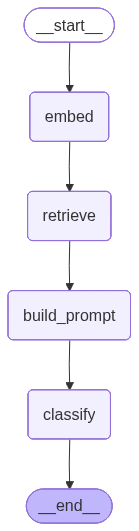

In [18]:
from IPython.display import Image, display
from classifier.graph import create_graph

# Criar o grafo para visualização
pipeline = create_graph(retriever, classifier, classes, representatives)

# Visualizar a estrutura do grafo LangGraph
display(Image(pipeline.get_graph().draw_mermaid_png()))

In [20]:
from classifier.graph import classify_ticket

In [21]:
# Classificar usando o pipeline completo
# A função classify_ticket encapsula todo o fluxo: retrieve → classify
details_graph = classify_ticket(
    ticket=query,
    retriever=retriever,
    classifier=classifier,
    classes=classes,
    reference_tickets=representatives,
)

print(f"Classe real: {true_class}")
print(f"Classe predita: {details_graph.result.classe}")
print(f"Justificativa: {details_graph.result.justificativa}")
print(f"\nCorreto: {details_graph.result.classe == true_class}")

Classe real: Access
Classe predita: Access
Justificativa: O ticket solicita a habilitação de um cartão de acesso para o December, com palavras-chave como 'enable access card', 'december pm' e 'card importance high'. 

Correto: True


## 7. Avaliação do Classificador

Agora vamos avaliar o desempenho do classificador nos 200 tickets de teste.

### Métricas Utilizadas

- **Accuracy:** Proporção de classificações corretas
- **F1 Macro:** Média não-ponderada do F1 por classe (trata todas as classes igualmente, importante para datasets desbalanceados)
- **Confusion Matrix:** Visualiza erros de classificação entre classes

### Tratamento de Erros

LLMs podem ocasionalmente retornar JSON malformado, ou a API pode apresentar erros. Para lidar com isso:

**Erros de JSON (parsing):**
1. **Primeira tentativa:** Envia o prompt normal para a LLM
2. **Se JSON inválido:** Continua a conversa adicionando a resposta do assistant e um prompt de correção:
   ```
   Sua resposta anterior não está no formato JSON válido.
   Por favor, responda APENAS com JSON válido no formato:
   {"classe": "<categoria>", "justificativa": "<explicação>"}
   ```
3. **Segunda tentativa:** LLM recebe o contexto completo da conversa e tenta corrigir
4. **Se falhar novamente:** O ticket é marcado como erro e reportado separadamente

**Erros de API:**
- Erros de autenticação (401), rate limit (429), ou outros erros da API são capturados
- O ticket é marcado como erro com o motivo específico
- A avaliação continua com os próximos tickets

Este approach garante que:
- Um erro pontual não interrompe toda a avaliação
- A LLM tem chance de se corrigir com contexto adicional
- Erros persistentes são documentados para análise posterior

In [ ]:
from classifier.metrics import evaluate, print_report, plot_confusion_matrix
from classifier.llm import ClassificationError
from tqdm import tqdm

In [ ]:
# Classificar todos os tickets de teste
y_true = []
y_pred = []
results = []
classification_errors = []

print(f"Classificando {len(test_df)} tickets de teste...\n")

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Classificando"):
    ticket_text = row["Document"]
    true_label = row["Topic_group"]
    
    try:
        details = classify_ticket(
            ticket=ticket_text,
            retriever=retriever,
            classifier=classifier,
            classes=classes,
            reference_tickets=representatives,
        )
        
        y_true.append(true_label)
        y_pred.append(details.result.classe)
        results.append({
            "ticket": ticket_text,
            "true": true_label,
            "pred": details.result.classe,
            "justificativa": details.result.justificativa,
            "correct": true_label == details.result.classe,
        })
    except ClassificationError as e:
        classification_errors.append({
            "ticket": ticket_text,
            "true": true_label,
            "reason": e.reason,
            "raw_response": e.raw_response,
        })

print(f"\nClassificação concluída!")
print(f"Classificados com sucesso: {len(results)}")
if classification_errors:
    print(f"Erros de classificação (JSON inválido): {len(classification_errors)}")

In [ ]:
# Calcular métricas
metrics = evaluate(y_true, y_pred, classes)
print_report(metrics, classes)

In [ ]:
# Visualizar confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"], classes, title="Confusion Matrix - Classificador RAG")

### Análise de Erros

Existem dois tipos de erros na avaliação:

1. **Erros de classificação:** A LLM retornou um JSON válido, mas a classe predita difere da classe real
2. **Erros de parsing:** A LLM não retornou JSON válido mesmo após retry (tickets não incluídos nas métricas)

Abaixo analisamos os erros de classificação para entender os padrões de confusão entre classes.

In [ ]:
# Filtrar erros
errors = [r for r in results if not r["correct"]]
print(f"Total de erros: {len(errors)} de {len(results)} ({100 * len(errors) / len(results):.1f}%)\n")

# Mostrar alguns exemplos de erros
print("=" * 80)
print("EXEMPLOS DE ERROS DE CLASSIFICAÇÃO")
print("=" * 80)

for i, error in enumerate(errors[:5], 1):
    print(f"\n--- Erro {i} ---")
    print(f"Classe real:     {error['true']}")
    print(f"Classe predita:  {error['pred']}")
    print(f"Justificativa:   {error['justificativa']}")
    print(f"Ticket:          {error['ticket'][:200]}...")

In [ ]:
# Distribuição de erros por classe
from collections import Counter

print("Distribuição de erros por classe real:")
error_by_true = Counter(e["true"] for e in errors)
for cls, count in sorted(error_by_true.items(), key=lambda x: -x[1]):
    print(f"  {cls}: {count} erros")

print("\nConfusões mais comuns (real → predito):")
confusion_pairs = Counter((e["true"], e["pred"]) for e in errors)
for (true, pred), count in confusion_pairs.most_common(10):
    print(f"  {true} → {pred}: {count}x")

## 8. Execução via CLI

Para executar a avaliação completa com todos os 200 tickets de teste, utilize a interface de linha de comando:

```bash
# Execução básica (200 tickets)
uv run python main.py

# Com parâmetros personalizados
uv run python main.py \
    --dataset dataset.csv \
    --output output/ \
    --test-size 200 \
    --k-similar 5 \
    --verbose

# Ver todas as opções
uv run python main.py --help
```

### Arquivos de Saída

A execução gera três arquivos no diretório `output/`:

| Arquivo | Descrição |
|---------|-----------|
| `classifications.json` | Relatório detalhado de todas as classificações (ticket, classes, prompts) |
| `metrics.json` | Métricas de avaliação (accuracy, F1, confusion matrix) |
| `run.log` | Log detalhado da execução |

### Estrutura do `classifications.json`

```json
{
  "metadata": {"timestamp": "...", "dataset": "...", "test_size": 200, ...},
  "summary": {"total": 200, "classified": 198, "errors": 2, "correct": 175},
  "classifications": [
    {
      "ticket": "texto do ticket...",
      "true_class": "Hardware",
      "predicted_class": "Hardware",
      "justification": "O ticket menciona...",
      "correct": true,
      "system_prompt": "Você é um classificador...",
      "user_prompt": "Classifique o seguinte ticket...",
      "similar_tickets": [{"text": "...", "class": "Hardware", "score": 0.85}],
      "retries": 0
    }
  ],
  "errors": [...]
}
```